#### Copyright © 2023 Taeyoung Kim and Mingi Kang. All rights reserved. ####

This is the solution for the homework assignment of the Machine Learning and Optimization lecture for WS2023. 

In [1]:
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

batch_size = 4

trainset_full = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset_full = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


### part 1

In [3]:
# Class labels 
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Map selected class names to  indices
selected_classes = ['cat', 'dog', 'ship']
class_indices = {classes.index(cls): cls for cls in selected_classes}

In [4]:
# Function to filter and select for classes
def filter_indices(dataset, class_indices, limit_per_class):
    selected_indices = {cls: [] for cls in class_indices.values()}
    for i in range(len(dataset)):
        _, label = dataset[i]
        if label in class_indices and len(selected_indices[classes[label]]) < limit_per_class:
            selected_indices[classes[label]].append(i)
    return [index for cls in selected_indices for index in selected_indices[cls]]

In [5]:
# Apply filter
train_indices = filter_indices(trainset_full, class_indices, 3000)
test_indices = filter_indices(testset_full, class_indices, 1000)

In [6]:
# Create for training and test datasets
trainset = Subset(trainset_full, train_indices)
testset = Subset(testset_full, test_indices)

In [7]:
# Initialize dataload
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

In [8]:
print(f"Training set size: {len(trainset)}")
print(f"Test set size: {len(testset)}")

Training set size: 9000
Test set size: 3000


### part 2

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [10]:
# Define NN Architecture
class SimpleNeuralNet(nn.Module):
    def __init__(self):
        super(SimpleNeuralNet, self).__init__()
        # input dimension is 32*32*3 = 3072
        self.fc1 = nn.Linear(3072, 512)  # First layer
        self.fc2 = nn.Linear(512, 3)     # Output layer with 3 units 
        
    def forward(self, x):
        # Flatten the input x keeping the batch dimension
        x = x.view(-1, 3072)  # Flatten the images into vectors of size 3072
        x = F.relu(self.fc1(x))  # Apply ReLU after first 
        x = self.fc2(x)  # No activation in output 
        return x

In [11]:
# Create SimpleNeuralNet
simple_net = SimpleNeuralNet()

In [12]:
# Print NN Architecture
print(simple_net)

SimpleNeuralNet(
  (fc1): Linear(in_features=3072, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=3, bias=True)
)


### part 3

In [13]:
# # Neural Network Def
# class SimpleNeuralNet(nn.Module):
#     def __init__(self):
#         super(SimpleNeuralNet, self).__init__()
#         self.fc1 = nn.Linear(3072, 512)
#         self.fc2 = nn.Linear(512, 3)

#     def forward(self, x):
#         x = x.view(-1, 3072)
#         x = F.relu(self.fc1(x))
#         x = self.fc2(x)
#         return x

In [14]:
# Loading CIFAR10 Dataset
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

batch_size = 4

trainset_full = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset_full = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [15]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
selected_classes = ['cat', 'dog', 'ship']
class_indices = {classes.index(cls): cls for cls in selected_classes}


In [16]:
def filter_indices_and_adjust_labels(dataset, class_indices, limit_per_class):
    selected_indices = []
    selected_labels = []
    for i in range(len(dataset)):
        image, label = dataset[i]
        if label in class_indices and len([idx for idx, l in zip(selected_indices, selected_labels) if l == label]) < limit_per_class:
            selected_indices.append(i)
            # Adjust the label to be within 0, 1, 2
            selected_labels.append(list(class_indices).index(label))
    return selected_indices, selected_labels

In [17]:
# Apply updated function
train_indices, train_labels = filter_indices_and_adjust_labels(trainset_full, class_indices, 3000)
test_indices, test_labels = filter_indices_and_adjust_labels(testset_full, class_indices, 1000)

In [18]:
# customizing datasets with adjusted label
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, indices, labels):
        self.dataset = dataset
        self.indices = indices
        self.labels = labels

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        image, _ = self.dataset[self.indices[idx]]
        label = self.labels[idx]
        return image, label

In [19]:
# new subsets
trainset = CustomDataset(trainset_full, train_indices, train_labels)
testset = CustomDataset(testset_full, test_indices, test_labels)

# dataloaders
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)


In [20]:
# Initialize NN
simple_net = SimpleNeuralNet()

In [21]:
# Define  SGD Optimizer and Lossfunction
optimizer = optim.SGD(simple_net.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

In [22]:
def train_network(network, train_loader, test_loader, optimizer, criterion, epochs=10):
    best_accuracy = 0
    best_model = None
    train_accuracies = []
    test_accuracies = []

    for epoch in range(epochs):
        network.train()
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = network(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Calculate training accuracy
        correct = 0
        total = 0
        with torch.no_grad():
            for data in train_loader:
                images, labels = data
                outputs = network(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        train_accuracy = 100 * correct / total
        train_accuracies.append(train_accuracy)

        # Calculate test accuracy
        correct = 0
        total = 0
        with torch.no_grad():
            for data in test_loader:
                images, labels = data
                outputs = network(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        test_accuracy = 100 * correct / total
        test_accuracies.append(test_accuracy)

        # Save the best model
        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy
            best_model = network.state_dict()

        print(f'Epoch {epoch + 1}, Loss: {running_loss / len(train_loader)}, Train Accuracy: {train_accuracy}%, Test Accuracy: {test_accuracy}%')

    return best_model, train_accuracies, test_accuracies

In [23]:
best_model, train_accuracies, test_accuracies = train_network(simple_net, trainloader, testloader, optimizer, criterion, epochs=10)

Epoch 1, Loss: 0.7101030101319155, Train Accuracy: 70.07333333333334%, Test Accuracy: 66.23333333333333%
Epoch 2, Loss: 0.6385823744162917, Train Accuracy: 72.46%, Test Accuracy: 69.6%
Epoch 3, Loss: 0.6038221256534259, Train Accuracy: 72.84%, Test Accuracy: 68.53333333333333%
Epoch 4, Loss: 0.5742990286308962, Train Accuracy: 74.69333333333333%, Test Accuracy: 67.8%
Epoch 5, Loss: 0.5482889502820326, Train Accuracy: 77.25333333333333%, Test Accuracy: 69.13333333333334%
Epoch 6, Loss: 0.5257379165377778, Train Accuracy: 79.44666666666667%, Test Accuracy: 69.06666666666666%
Epoch 7, Loss: 0.5012858099333322, Train Accuracy: 78.97333333333333%, Test Accuracy: 68.9%
Epoch 8, Loss: 0.4796107507432811, Train Accuracy: 83.31333333333333%, Test Accuracy: 70.73333333333333%
Epoch 9, Loss: 0.44933737107761745, Train Accuracy: 82.54%, Test Accuracy: 68.4%
Epoch 10, Loss: 0.4336196424173114, Train Accuracy: 84.56%, Test Accuracy: 69.1%


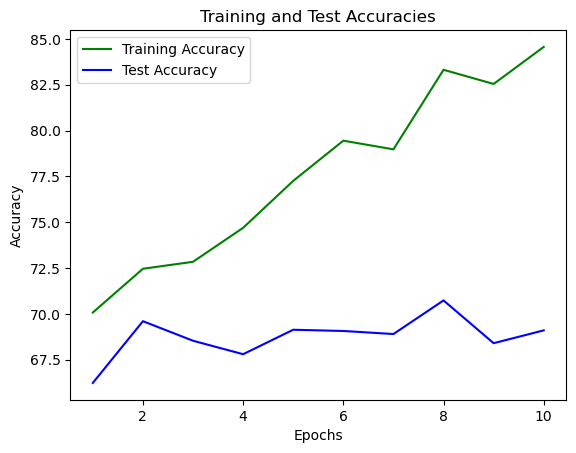

In [24]:
# Plotting the training and test accuracies
epochs = range(1, 11)
plt.plot(epochs, train_accuracies, 'g', label='Training Accuracy')
plt.plot(epochs, test_accuracies, 'b', label='Test Accuracy')
plt.title('Training and Test Accuracies')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


### part 4

In [25]:
# Load the best model
simple_net.load_state_dict(best_model)

<All keys matched successfully>

In [26]:
# Function to evaluate the model
def evaluate_model(network, test_loader):
    class_correct = list(0. for i in range(3))
    class_total = list(0. for i in range(3))
    class_names = ['cat', 'dog', 'ship']

    with torch.no_grad():
        network.eval()
        total_correct = 0
        total_images = 0
        for data in test_loader:
            images, labels = data
            outputs = network(images)
            _, predicted = torch.max(outputs, 1)
            total_images += labels.size(0)
            total_correct += (predicted == labels).sum().item()
            
    
            correct = (predicted == labels).squeeze()
            for i in range(len(labels)):
                label = labels[i]
                class_correct[label] += correct[i].item()
                class_total[label] += 1

    overall_accuracy = total_correct / total_images * 100
    class_accuracies = {class_names[i]: class_correct[i] / class_total[i] * 100 for i in range(3)}

    return overall_accuracy, class_accuracies


In [27]:
# Evaluate model
overall_accuracy, class_accuracies = evaluate_model(simple_net, testloader)

Overall Test Accuracy: 69.1%
Test Accuracy per Class:
 - cat: 61.0%
 - dog: 61.4%
 - ship: 84.89999999999999%


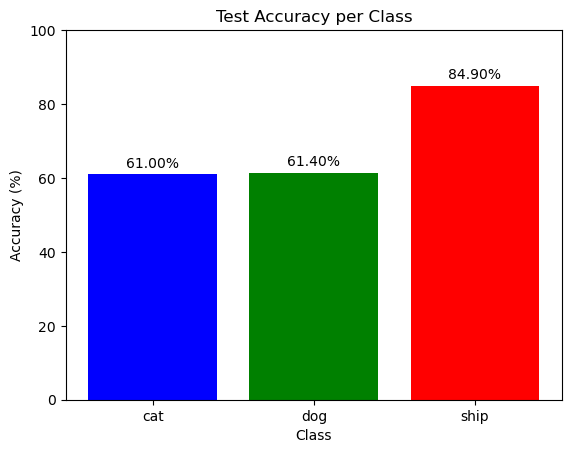

In [28]:
# Print accuracies
print(f"Overall Test Accuracy: {overall_accuracy}%")
print("Test Accuracy per Class:")
for class_name in class_accuracies:
    print(f" - {class_name}: {class_accuracies[class_name]}%")

# Plotting accuracies
class_names = list(class_accuracies.keys())
accuracies = [class_accuracies[class_name] for class_name in class_names]

plt.bar(class_names, accuracies, color=['blue', 'green', 'red'])
plt.xlabel('Class')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy per Class')
plt.ylim([0, 100])
for i, v in enumerate(accuracies):
    plt.text(i, v + 1, f"{v:.2f}%", ha='center', va='bottom')
plt.show()

In [29]:
# The best performing class
best_class = max(class_accuracies, key=class_accuracies.get)
print(f"Best performing class: {best_class}")

Best performing class: ship


#### Reason
- Distinctive Features: Ships have more uniform and simpler shapes
- Background Consistency: Ship images often feature consistent backgrounds(water, sky), aiding recognition
- Lower Intra Class Variation: ships have less variability in appearance
- Training Data Quality: Ship in dataset can be clearer and more consistent
- Model Suitability: The NN architecture and training can be better at capturing ship features.